In [1]:
! pip install evaluate
import torch
from datasets import load_dataset
import transformers
from transformers import (AutoTokenizer, 
                          AutoModelForSequenceClassification, 
                          TrainingArguments, 
                          Trainer,
                          DataCollatorWithPadding)
import evaluate
import numpy as np
from typing import Dict, Any
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
transformers.utils.logging.set_verbosity_debug()

# torch.autograd.set_detect_anomaly(True)
# torch.autograd.set_detect_anomaly(False)


2026-01-23 13:03:23.639131: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1769173404.088063      31 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1769173404.214231      31 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1769173405.276907      31 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769173405.276962      31 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769173405.276964      31 computation_placer.cc:177] computation placer alr

In [2]:

# Login using e.g. `huggingface-cli login` to access this dataset
ds = load_dataset("iitolstykh/LLMTrace_classification")
print(ds)

README.md: 0.00B [00:00, ?B/s]

train.jsonl:   0%|          | 0.00/1.40G [00:00<?, ?B/s]

valid.jsonl:   0%|          | 0.00/292M [00:00<?, ?B/s]

test.jsonl:   0%|          | 0.00/318M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/411440 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/86696 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/90950 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['lang', 'label', 'model', 'data_type', 'prompt_type', 'topic_id', 'text', 'prompt'],
        num_rows: 411440
    })
    validation: Dataset({
        features: ['lang', 'label', 'model', 'data_type', 'prompt_type', 'topic_id', 'text', 'prompt'],
        num_rows: 86696
    })
    test: Dataset({
        features: ['lang', 'label', 'model', 'data_type', 'prompt_type', 'topic_id', 'text', 'prompt'],
        num_rows: 90950
    })
})


In [3]:
# чекпоинт модели
checkpoint = "google-bert/bert-base-multilingual-cased"
# токенизатор для модели
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
# дата коллатор
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, )

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--google-bert--bert-base-multilingual-cased/snapshots/3f076fdb1ab68d5b2880cb87a0886f315b8146f8/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.57.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 119547
}



vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--google-bert--bert-base-multilingual-cased/snapshots/3f076fdb1ab68d5b2880cb87a0886f315b8146f8/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--google-bert--bert-base-multilingual-cased/snapshots/3f076fdb1ab68d5b2880cb87a0886f315b8146f8/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--google-bert--bert-base-multilingual-cased/snapshots/3f076fdb1ab68d5b2880cb87a0886f315b8146f8/tokenizer_config.json
loading file chat_template.jinja from cache at None
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--google-bert--bert-base-multilingual-cased/snapshots/3f076fdb1ab68d5b2880cb87a0886f315b8146f8/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "atten

In [4]:
def tokenize_example(example: Dict[str, Any]) -> Dict[str, Any]:
    """
    Функция токенизации
    --------------------------
    Parameters:
    example : datasets.DatasetDict
        датасет из библиотеки HF Datasets

     Returns:
    --------
    datasets.DatasetDict
        Токенизированный датасет
    """
    return tokenizer(
        example['text'],
        truncation = True,
        max_length = 256,
    )

In [5]:
ds['train'].column_names

['lang',
 'label',
 'model',
 'data_type',
 'prompt_type',
 'topic_id',
 'text',
 'prompt']

In [6]:
tokenized_ds = ds.map(tokenize_example, 
                      batched=True,
                      remove_columns = 
                      [name for name in ds['train'].column_names if name != 'label'])
tokenized_ds = tokenized_ds.class_encode_column('label')

Map:   0%|          | 0/411440 [00:00<?, ? examples/s]

Map:   0%|          | 0/86696 [00:00<?, ? examples/s]

Map:   0%|          | 0/90950 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/411440 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/86696 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/90950 [00:00<?, ? examples/s]

In [7]:
accuracy = evaluate.load('accuracy')
precision = evaluate.load('precision')
recall = evaluate.load('recall')
f1 = evaluate.load('f1')
metrics_func = [accuracy, precision, recall, f1]
def compute_metrics(eval_pred):
    """
    Вычисляет метрики по предсказанию модели и меткам
    """
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    result = dict()
    for func in metrics_func:
        result.update(func.compute(predictions=preds, references=labels))
    return result

In [8]:
compute_metrics(([[0.9, 0.1], [0.05, 0.95]], [1, 0]))

{'accuracy': 0.0, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}

In [9]:
from transformers import TrainerCallback

class DebugCallback(TrainerCallback):
    def on_step_begin(self, args, state, control, **kwargs):
        if state.global_step % 500 == 0:  # логируем каждые 10 шагов
            print(f"[DEBUG] Начало шага {state.global_step}")

    def on_step_end(self, args, state, control, **kwargs):
        if state.global_step % 500 == 0:
            print(f"[DEBUG] Завершён шаг {state.global_step}")

    def on_epoch_begin(self, args, state, control, **kwargs):
        print(f"[DEBUG] Начало эпохи {state.epoch}")

    def on_epoch_end(self, args, state, control, **kwargs):
        print(f"[DEBUG] Завершена эпоха {state.epoch}")
        print(f"    Метрики: {state.log_history[-1] if state.log_history else 'нет'}")

In [10]:


# аргументы для обучения
training_args = TrainingArguments(
    output_dir = "/kaggle/working/output/" + checkpoint + "_llm_trace_classification",
    save_strategy = 'epoch',
    eval_strategy = 'epoch',
    logging_strategy = 'epoch',
    
    learning_rate = 2e-5,
    num_train_epochs = 3,
    weight_decay = 0.001,
    # fp16 = True,
    
    per_device_train_batch_size = 32,
    per_device_eval_batch_size = 32,
    dataloader_num_workers = 0,
    logging_dir = '/kaggle/working/logging_dir',
    logging_steps = 50,
    load_best_model_at_end = True,
    metric_for_best_model = 'f1',
    disable_tqdm=False,
    log_level = 'debug',
    log_level_replica = 'debug',
    report_to="tensorboard",
)

PyTorch: setting up devices


In [11]:
# модель
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels = 2)
demo_train =  tokenized_ds['train'].shuffle(seed=42).select(range(1024))
demo_valid =  tokenized_ds['validation'].shuffle(seed=42).select(range(1024))
# print(demo_train, demo_valid)
# wandb.init(project='LLMTrace-classification', name='run-01')


trainer = Trainer(
    model = model,
    args = training_args,
    data_collator = data_collator,
    train_dataset = tokenized_ds['train'],
    eval_dataset = tokenized_ds['validation'],
    # train_dataset = demo_train,
    # eval_dataset = demo_valid,
    tokenizer = tokenizer,
    compute_metrics = compute_metrics,
    callbacks=[DebugCallback()]
    
)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--google-bert--bert-base-multilingual-cased/snapshots/3f076fdb1ab68d5b2880cb87a0886f315b8146f8/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.57.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 119547
}



model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

loading weights file model.safetensors from cache at /root/.cache/huggingface/hub/models--google-bert--bert-base-multilingual-cased/snapshots/3f076fdb1ab68d5b2880cb87a0886f315b8146f8/model.safetensors
A pretrained model of type `BertForSequenceClassification` contains parameters that have been renamed internally (a few are listed below but more are present in the model):
* `cls.predictions.transform.LayerNorm.beta` -> `cls.predictions.transform.LayerNorm.bias`
* `cls.predictions.transform.LayerNorm.gamma` -> `cls.predictions.transform.LayerNorm.weight`
If you are using a model from the Hub, consider submitting a PR to adjust these weights and help future users.
Some weights of the model checkpoint at google-bert/bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dens

In [12]:
# trainer.train_dataset.class_encode_column('label')[0]

In [13]:
trainer.train_dataset[0]

for batch in trainer.get_train_dataloader():
    print(batch)
    break

{'input_ids': tensor([[   101,  70615,  10135,  ...,      0,      0,      0],
        [   101,    519,  55522,  ...,    117,  10791,    102],
        [   101,    523,  20785,  ...,  61342,    119,    102],
        ...,
        [   101,  10747,  99345,  ...,      0,      0,      0],
        [   101,    511,  37556,  ...,      0,      0,      0],
        [   101,  14418, 103970,  ...,  72701, 102006,    102]],
       device='cuda:0'), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]], device='cuda:0'), 'labels': tensor([1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1

In [14]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())

True
2


In [15]:
# torch.autograd.set_detect_anomaly(False)

In [16]:
trainer.train()

Currently training with a batch size of: 64
***** Running training *****
  Num examples = 411,440
  Num Epochs = 3
  Instantaneous batch size per device = 32
  Training with DataParallel so batch size has been adjusted to: 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 19,287
  Number of trainable parameters = 177,854,978


[DEBUG] Начало эпохи 0
[DEBUG] Начало шага 0


/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.177200,0.162936,0.941416,0.940404,0.911244,0.925594
2,0.103000,0.188147,0.941024,0.948741,0.901206,0.924363
3,0.070300,0.291838,0.930562,0.954557,0.867659,0.909036


[DEBUG] Завершён шаг 500
[DEBUG] Начало шага 500
[DEBUG] Завершён шаг 1000
[DEBUG] Начало шага 1000
[DEBUG] Завершён шаг 1500
[DEBUG] Начало шага 1500
[DEBUG] Завершён шаг 2000
[DEBUG] Начало шага 2000
[DEBUG] Завершён шаг 2500
[DEBUG] Начало шага 2500
[DEBUG] Завершён шаг 3000
[DEBUG] Начало шага 3000
[DEBUG] Завершён шаг 3500
[DEBUG] Начало шага 3500
[DEBUG] Завершён шаг 4000
[DEBUG] Начало шага 4000
[DEBUG] Завершён шаг 4500
[DEBUG] Начало шага 4500
[DEBUG] Завершён шаг 5000
[DEBUG] Начало шага 5000
[DEBUG] Завершён шаг 5500
[DEBUG] Начало шага 5500
[DEBUG] Завершён шаг 6000
[DEBUG] Начало шага 6000



***** Running Evaluation *****
  Num examples = 86696
  Batch size = 64


[DEBUG] Завершена эпоха 1.0
    Метрики: нет


Saving model checkpoint to /kaggle/working/output/google-bert/bert-base-multilingual-cased_llm_trace_classification/checkpoint-6429
Configuration saved in /kaggle/working/output/google-bert/bert-base-multilingual-cased_llm_trace_classification/checkpoint-6429/config.json
Model weights saved in /kaggle/working/output/google-bert/bert-base-multilingual-cased_llm_trace_classification/checkpoint-6429/model.safetensors
tokenizer config file saved in /kaggle/working/output/google-bert/bert-base-multilingual-cased_llm_trace_classification/checkpoint-6429/tokenizer_config.json
Special tokens file saved in /kaggle/working/output/google-bert/bert-base-multilingual-cased_llm_trace_classification/checkpoint-6429/special_tokens_map.json


[DEBUG] Начало эпохи 1.0


/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[DEBUG] Завершён шаг 6500
[DEBUG] Начало шага 6500
[DEBUG] Завершён шаг 7000
[DEBUG] Начало шага 7000
[DEBUG] Завершён шаг 7500
[DEBUG] Начало шага 7500
[DEBUG] Завершён шаг 8000
[DEBUG] Начало шага 8000
[DEBUG] Завершён шаг 8500
[DEBUG] Начало шага 8500
[DEBUG] Завершён шаг 9000
[DEBUG] Начало шага 9000
[DEBUG] Завершён шаг 9500
[DEBUG] Начало шага 9500
[DEBUG] Завершён шаг 10000
[DEBUG] Начало шага 10000
[DEBUG] Завершён шаг 10500
[DEBUG] Начало шага 10500
[DEBUG] Завершён шаг 11000
[DEBUG] Начало шага 11000
[DEBUG] Завершён шаг 11500
[DEBUG] Начало шага 11500
[DEBUG] Завершён шаг 12000
[DEBUG] Начало шага 12000
[DEBUG] Завершён шаг 12500
[DEBUG] Начало шага 12500



***** Running Evaluation *****
  Num examples = 86696
  Batch size = 64


[DEBUG] Завершена эпоха 2.0
    Метрики: {'eval_loss': 0.16293606162071228, 'eval_accuracy': 0.9414159822829197, 'eval_precision': 0.9404042508856012, 'eval_recall': 0.9112437983154494, 'eval_f1': 0.9255944096922107, 'eval_runtime': 782.536, 'eval_samples_per_second': 110.789, 'eval_steps_per_second': 1.732, 'epoch': 1.0, 'step': 6429}


Saving model checkpoint to /kaggle/working/output/google-bert/bert-base-multilingual-cased_llm_trace_classification/checkpoint-12858
Configuration saved in /kaggle/working/output/google-bert/bert-base-multilingual-cased_llm_trace_classification/checkpoint-12858/config.json
Model weights saved in /kaggle/working/output/google-bert/bert-base-multilingual-cased_llm_trace_classification/checkpoint-12858/model.safetensors
tokenizer config file saved in /kaggle/working/output/google-bert/bert-base-multilingual-cased_llm_trace_classification/checkpoint-12858/tokenizer_config.json
Special tokens file saved in /kaggle/working/output/google-bert/bert-base-multilingual-cased_llm_trace_classification/checkpoint-12858/special_tokens_map.json


[DEBUG] Начало эпохи 2.0


/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[DEBUG] Завершён шаг 13000
[DEBUG] Начало шага 13000
[DEBUG] Завершён шаг 13500
[DEBUG] Начало шага 13500
[DEBUG] Завершён шаг 14000
[DEBUG] Начало шага 14000
[DEBUG] Завершён шаг 14500
[DEBUG] Начало шага 14500
[DEBUG] Завершён шаг 15000
[DEBUG] Начало шага 15000
[DEBUG] Завершён шаг 15500
[DEBUG] Начало шага 15500
[DEBUG] Завершён шаг 16000
[DEBUG] Начало шага 16000
[DEBUG] Завершён шаг 16500
[DEBUG] Начало шага 16500
[DEBUG] Завершён шаг 17000
[DEBUG] Начало шага 17000
[DEBUG] Завершён шаг 17500
[DEBUG] Начало шага 17500
[DEBUG] Завершён шаг 18000
[DEBUG] Начало шага 18000
[DEBUG] Завершён шаг 18500
[DEBUG] Начало шага 18500
[DEBUG] Завершён шаг 19000
[DEBUG] Начало шага 19000



***** Running Evaluation *****
  Num examples = 86696
  Batch size = 64


[DEBUG] Завершена эпоха 3.0
    Метрики: {'eval_loss': 0.1881466805934906, 'eval_accuracy': 0.941023807326751, 'eval_precision': 0.9487413075825211, 'eval_recall': 0.9012057228568132, 'eval_f1': 0.924362786431752, 'eval_runtime': 782.1418, 'eval_samples_per_second': 110.844, 'eval_steps_per_second': 1.732, 'epoch': 2.0, 'step': 12858}


Saving model checkpoint to /kaggle/working/output/google-bert/bert-base-multilingual-cased_llm_trace_classification/checkpoint-19287
Configuration saved in /kaggle/working/output/google-bert/bert-base-multilingual-cased_llm_trace_classification/checkpoint-19287/config.json
Model weights saved in /kaggle/working/output/google-bert/bert-base-multilingual-cased_llm_trace_classification/checkpoint-19287/model.safetensors
tokenizer config file saved in /kaggle/working/output/google-bert/bert-base-multilingual-cased_llm_trace_classification/checkpoint-19287/tokenizer_config.json
Special tokens file saved in /kaggle/working/output/google-bert/bert-base-multilingual-cased_llm_trace_classification/checkpoint-19287/special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from /kaggle/working/output/google-bert/bert-base-multilingual-cased_llm_trace_classification/checkpoint-6429 (score: 0.9255944096922107).


TrainOutput(global_step=19287, training_loss=0.11681380484284265, metrics={'train_runtime': 33660.251, 'train_samples_per_second': 36.67, 'train_steps_per_second': 0.573, 'total_flos': 1.623816189259776e+17, 'train_loss': 0.11681380484284265, 'epoch': 3.0})

In [17]:
df = pd.DataFrame(trainer.state.log_history)
df_train = df[df['loss'].notna()].dropna(axis=1).reset_index()
df_eval = df[df['eval_loss'].notna()].dropna(axis=1).reset_index()
# df_train
# df_eval['eval_loss']

In [18]:
df_eval_metrics = df_eval[['epoch',  'eval_accuracy', 'eval_precision', 'eval_recall', 'eval_f1']]
df_loss = pd.concat([df_train[['epoch','loss']], df_eval[['eval_loss']]], axis=1)
# df_loss
df_eval_metrics

,epoch,eval_accuracy,eval_precision,eval_recall,eval_f1
0,1.0,0.941416,0.940404,0.911244,0.925594
1,2.0,0.941024,0.948741,0.901206,0.924363
2,3.0,0.930562,0.954557,0.867659,0.909036


/tmp/ipykernel_31/2642578166.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[1].legend()


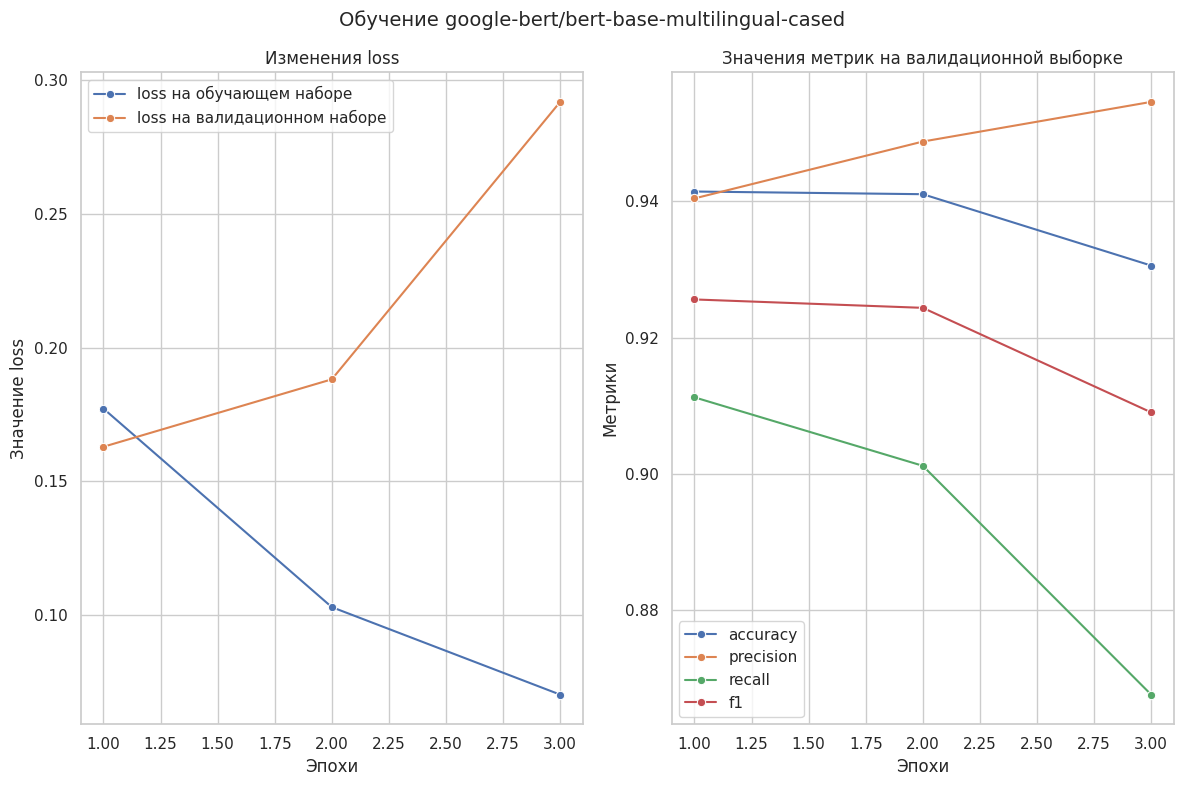

In [19]:
# Настройка общего стиля
sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,8))
plt.suptitle(f'Обучение {checkpoint}', fontsize=14, )
plt.plot()
#loss plot
ax[0].set_xlabel('Эпохи')
ax[0].set_ylabel('Значение loss')
ax[0].set_title('Изменения loss')

sns.lineplot(ax=ax[0], data=df_loss, x='epoch', y='loss', label='loss на обучающем наборе', marker='o')
sns.lineplot(ax=ax[0], data=df_loss, x='epoch', y='eval_loss', label='loss на валидационном наборе',marker='o' )
# for i in range(df_loss.shape[0]):
    # ax[0].text(x=df_loss.epoch.iloc[i], y=df_loss.loss.iloc[i] + 0.006, s=f"{df_loss.loss.iloc[i]:.4f}",fontdict=dict(color='black', size=10), horizontalalignment='center')
    # ax[0].text(x=df_loss.epoch.iloc[i], y=df_loss.eval_loss.iloc[i] - 0.006, s=f"{df_loss.eval_loss.iloc[i]:.4f}",fontdict=dict(color='black', size=10), horizontalalignment='center')


ax[0].legend()

ax[1].set_xlabel('Эпохи')
ax[1].set_ylabel('Метрики')
ax[1].set_title('Значения метрик на валидационной выборке')
# ax[1].plot('epoch','eval_accuracy', data=df_eval_metrics)
ax[1].legend()
for metric in df_eval_metrics.drop('epoch', axis=1).columns:
    sns.lineplot(ax=ax[1], data=df_eval_metrics, x='epoch', y=metric, label=metric[5:], marker='o')

plt.savefig(f'/kaggle/working/output/{checkpoint}_llm_trace_classification/train.png')
plt.tight_layout()
plt.show()

In [20]:
# demo_test = tokenized_ds['test'].select(range(1024))
# test_metrics = trainer.evaluate(demo_test)

In [21]:
# logits, labels, test_metrics = trainer.predict(demo_test)
logits, labels, test_metrics = trainer.predict(tokenized_ds['test'])
# logits


***** Running Prediction *****
  Num examples = 90950
  Batch size = 64
/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


In [22]:
import json

with open(f'/kaggle/working/output/{checkpoint}_test_metrics.json', 'w', encoding='utf-8') as f:
    json.dump(test_metrics, f, indent=4, ensure_ascii=False)

In [23]:
metrics

NameError: name 'metrics' is not defined

In [ ]:
pred_labels = np.argmax(logits, axis=-1)

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

conf_mat = confusion_matrix(labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=['ИИ', 'Человек'])
disp.plot()
plt.xlabel('Предсказанные метки')
plt.ylabel('Истинный класс')
plt.title('Матрица ошибок')
plt.grid(False)
plt.savefig(f'/kaggle/working/output/{checkpoint}_llm_trace_classification/confusion_matrix.png')
plt.show()
